In [71]:
#imports 
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset


import spacy
import statistics
import torchtext
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt


import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

In [72]:
torch.backends.cudnn.benchmark = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-4
MAX_EPOCHS = 100
NUM_GPU=1

In [73]:
class Vocabulary:
    def __init__(self, freq_threshold, spacy_eng=None):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        if spacy_eng==None:
            self.spacy_eng = spacy.load('en_core_web_sm')
        else:
            self.spacy_eng = spacy_eng

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        return [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None, freq_threshold=5,
                 train=True, split_val=0.2):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.df = pd.read_csv(caption_file)
        self.transform = transform
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df['caption'].tolist())
        
        self.train = train 
        self.split_val = split_val
        self._do_split_train_valid()
        
#         # Get img, caption columns
#         self.imgs = self.df["image"]
#         self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab

        
    def _do_split_train_valid(self):
        imgs_train, imgs_valid, caps_train, caps_valid = train_test_split(
            self.df["image"], self.df["caption"], 
            test_size=self.split_val, random_state=16
        )
        
        if self.train:
            self.imgs = imgs_train
            self.captions = caps_train
        else:
            self.imgs = imgs_valid
            self.captions = caps_valid
            
        self.imgs = self.imgs.tolist()
        self.captions = self.captions.tolist()
        

    def __len__(self):
        return len(self.imgs)
    
    def _numericalized_caption(self, caption):
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return numericalized_caption

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        ncaption = self._numericalized_caption(caption)

        return img, torch.tensor(ncaption)


class CaptionCollate:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)

        return imgs, targets
    

def flickr8k_dataloader(root_folder, caption_file, transform, train=True,
                        batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    
    dataset = FlickrDataset(root_folder, caption_file, transform=transform, train=train)
    PAD_IDX = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers,
                            shuffle=shuffle, pin_memory=pin_memory, 
                            collate_fn=CaptionCollate(pad_idx=PAD_IDX))
    
    return dataloader, dataset

In [74]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])


root_dir = "data/flickr8k/images/"
caption_file = "data/flickr8k/captions.txt"

train_loader, trainset = flickr8k_dataloader(root_dir, caption_file, transform=train_transform,  
                                             num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = flickr8k_dataloader(root_dir, caption_file, transform=valid_transform, 
                                             num_workers=NUM_WORKERS, shuffle=False, train=False)

In [75]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_cnn=False, resnet_model=models.resnet50):
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn
        resnet = resnet_model(pretrained=True)
        resnet = self._fine_tune(resnet)
        modules = list(resnet.children())[:-1]
        
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        
    def _fine_tune(self, resnet):
        if self.train_cnn:
            for param in resnet.parameters():
                param.requires_grad_(True)
        else:
            for param in resnet.parameters():
                param.requires_grad_(False)
                
        return resnet
    
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        embed = self.embed(features)
        embed = self.dropout(embed)
        return embed


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_size * 2, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        features = features.unsqueeze(dim=1)
        
        embeddings = self.dropout(self.embed(captions))
        
#         print(features.shape, embeddings.shape)
        
        embeddings = torch.cat((features, embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class ImageCaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionNet, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, states=None, max_length=20):
        result_caption = []

        with torch.no_grad():
            x = self.encoder(image).unsqueeze(dim=1)

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(1)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    result_caption.append(predicted.item())
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [76]:
class ImageCaptionTask(pl.LightningModule):
    def __init__(self, model, optimizers, criterion, scheduler=None):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.metric = Accuracy()
        
    def forward(self, imgs, captions):
        outputs = self.model(imgs, captions[:-1])
        return outputs
        
    
    def shared_step(self, batch, batch_idx):
        imgs, captions = batch
        outputs = self.model(imgs, captions)
        
        outputs_pre = outputs.view(-1, outputs.shape[2])
        captions_pre = captions.view(-1)
        loss = criterion(outputs_pre, captions_pre)
#         acc = (output.argmax(1) == cls).sum().item()
        acc = self.metric(outputs_preprocess.argmax(1), captions_preprocess)
        return loss, acc

    
    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.TrainResult(loss)
#         result.log_dict({'trn_loss': loss})
        result.log_dict({'trn_loss': loss, 'trn_acc':acc})
        
        return result
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
#         result.log_dict({'val_loss': loss})
        result.log_dict({'val_loss': loss, 'val_acc': acc})
        
        return result
    
    def configure_optimizers(self):
        if self.scheduler:
            return [self.optimizer], [self.scheduler]
        return self.optimizer
    
  

In [77]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)

model = ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
task = ImageCaptionTask(model, optimizer, criterion)

In [78]:
saved_checkpoint_path = '../saved_model/flickr8k_net_epoch=99.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
task.load_state_dict(checkpoint['state_dict'])
# model.load_state_dict(task.model.state_dict())
# task.load_from_checkpoint(saved_checkpoint_path, optimizers=optimizer, criterion=criterion)

<All keys matched successfully>

In [79]:
img, txt = validset[10]
img = img.unsqueeze(0)

result = model.caption_image(img, trainset.vocab)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['<SOS>', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these', 'little', 'these']


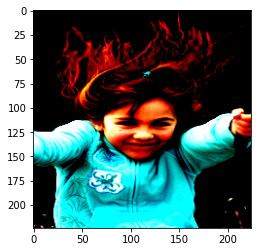

In [80]:
print(result)
plt.imshow(img.squeeze().permute(1,2,0), cmap='gray')